In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import cv2
import os
import glob
import sys
import shutil
from PIL import Image
from rasterio.plot import show
fp = r'D:\Data\ships\9\20170130_214420_0c37_3B_AnalyticMS_clip_toar'
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the file:
raster = rasterio.open(fp)

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Stack bands
rgb = np.dstack((red_norm, green_norm, blue_norm))

# View the color composite
plt.imshow(rgb)

RasterioIOError: D:/Data/ships/9/20170130_214420_0c37_3B_AnalyticMS_clip_toar: No such file or directory

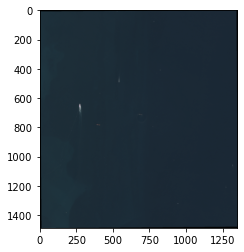

In [22]:
src_ds = rasterio.open(fp)
image = src_ds.read()
image = image.swapaxes(0,2).swapaxes(0,1)
image=bgr_to_rgb(image)
image = cv2.normalize(image,0,1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#image = crop(400,400,image)
plt.imshow(image)


In [4]:
#image preprocessing
#data loading

def load_tif(img_number,path):
    i = "3B_AnalyticMS_clip_toar.tif"
    basePath = path.format(img_number)
    path_string = glob.glob(os.path.join(basePath,'*{0}*'.format(i)))[0]
    img_fn = Path(path_string)
    src_ds = rasterio.open(img_fn)
    image = src_ds.read()
    image = image.swapaxes(0,2).swapaxes(0,1)
    return image

#image cropping without augmentation
#croping difficul eg. 100 is out of crop (900/900) needed to see ship
def crop(w,h,image):
    center_x=image.shape[0] / 2
    center_y=image.shape[1] / 2
    x = int(center_x - w/2)
    y = int(center_y - h/2)
    image_crop = image[y:y+h, x:x+w]
    return image_crop


def plot(image):
    #image_norm=cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image_norm=image
    image_rgb = image_norm[:,:,[0,1,2]]
    plt.figure(figsize=(16,16))
    plt.imshow(image_rgb)
    
def plot_rgb(image):
    #image_norm=cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image_norm=image
    plt.figure(figsize=(16,16))
    plt.imshow(image_norm)
    
def store_np(img, path):
    img_dst= Path(path.format(img_number))
    np.save(img_dst, img)
    
def bgrn_to_rgbn(img):
    imgcpy=img.copy()
    img[:,:,0]=imgcpy[:,:,2]
    img[:,:,2]=imgcpy[:,:,0]
    return img

def bgr_to_rgb(img):
    im_rgb = img[:, :, [2, 1, 0]]
    return im_rgb
def store_png(img, path):
    cv2.imwrite("{}.png".format(path), img)
    
#plot
def store_tif(img, path, src):
    with rasterio.Env():
        profile = src.profile
        profile.update(dtype=rasterio.uint8,count=4,compress='lzw')

    with rasterio.open(path, 'w', **profile) as dst:
        dst.write(img.astype(rasterio.uint8), 4)
  

    
    


In [27]:
#create new data set under path

def create_new_dataset(path, rgb_only):
    shutil.rmtree(path)
    os.makedirs(Path(path+"\\test\\ships"))
    os.makedirs(Path(path+"\\test\\non_ships"))
    os.makedirs(Path(path+"\\train\\ships"))
    os.makedirs(Path(path+"\\train\\non_ships"))
    
    def loop_images(path,tag, num_of_images):
        img_number=0
        c_test=0
        c_train=0
        while img_number <= num_of_images:
            image=load_tif(img_number,r"D:\\Data\\{}\{}\\".format(tag,img_number))
            if rgb_only:
                image=bgr_to_rgb(image)
            else:
                image=bgrn_to_rgbn(image)
            image = cv2.normalize(image,0,255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            image=crop(600,600,image)
            
            ran=np.random.rand(1)
            if ran <= 0.25: #test data
                store_png(image,"{}\\test\\{}\img{}".format(path,tag,img_number))
                c_test=c_test+1
            else:
                store_png(image,"{}\\train\\{}\img{}".format(path,tag,img_number))
                c_train=c_train+1
            img_number = img_number +1
        print("{} images of category {} in test".format(c_test,tag))
        print("{} images of category {} in train".format(c_train,tag))
    loop_images(path,"ships",871)
    loop_images(path,"non_ships",877)


    

    

In [72]:
create_new_dataset("D:\\Data\\data", False)

244 images of category ships in test
628 images of category ships in train
209 images of category non_ships in test
669 images of category non_ships in train


In [28]:
create_new_dataset("D:\\Data\\data_rgb", True)

203 images of category ships in test
669 images of category ships in train
246 images of category non_ships in test
632 images of category non_ships in train


In [6]:
create_new_dataset("D:\\Data\\data_rgb_kfold", True)


In [1]:
def create_new_dataset(path, rgb_only):
    shutil.rmtree(path)
    os.makedirs(Path(path+"\\train\\ships"))
    os.makedirs(Path(path+"\\train\\non_ships"))
    
    def loop_images(path,tag, num_of_images):
        img_number=0
        c_test=0
        c_train=0
        while img_number <= num_of_images:
            image=load_tif(img_number,r"D:\\Data\\{}\{}\\".format(tag,img_number))
            if rgb_only:
                image=bgr_to_rgb(image)
            else:
                image=bgrn_to_rgbn(image)
            image = cv2.normalize(image,0,255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            image=crop(600,600,image)
            store_png(image,"{}\\train\\{}\img{}".format(path,tag,img_number))
            img_number = img_number +1
    loop_images(path,"ships",871)
    loop_images(path,"non_ships",877)